# Dynamic FBA

In [1]:
%run 2.Ecoli_model.ipynb

Putrescine
ptrc_p
Putrescine
ptrc_c
Putrescine
ptrc_e
9.56477064220183
N-Acetyl-L-glutamate 5-semialdehyde
acg5sa_c
N2-Succinyl-L-glutamate 5-semialdehyde
sucgsa_c
L-Glutamate 5-semialdehyde
glu5sa_c
Ornithine
orn_e
Ornithine
orn_p
Ornithine
orn_c
2-Oxoglutarate
akg_e
2-Oxoglutarate
akg_c
2-Oxoglutarate
akg_p
L-Glutamate 1-semialdehyde
glu1sa_c
L-Glutamate
glu__L_c
L-Glutamate 5-semialdehyde
glu5sa_c
L-Glutamate
glu__L_e
L-Glutamate
glu__L_p
L-Glutamate 5-phosphate
glu5p_c
glu5sa_c + glu__L_c --> akg_c + orn_c
53.02333333333343
45.78742857142862
9.929142857142857
L-Arginine
arg__L_c
L-Arginine
arg__L_e
L-Arginine
arg__L_p
Urea CH4N2O
urea_c
Urea CH4N2O
urea_p
Urea CH4N2O
urea_e
H2O H2O
h2o_p
H2O H2O
h2o_c
H2O H2O
h2o_e
arg__L_c + h2o_c --> orn_c + urea_c
9.929142857142855


In [2]:
from os.path import dirname, join, pardir

from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable

Changing the lower bound of the putrescine exchange reaction to have it match what is found in litterature.
!!Here just tested with random value!!

In [3]:
model.reactions.EX_ptrc_e.lower_bound = 20

In [4]:
model.reactions.EX_ptrc_e

Reaction identifier,EX_ptrc_e
Name,Putrescine exchange
Memory address,0x07f3d5b651f40
Stoichiometry,ptrc_e --> Putrescine -->
GPR,
Lower bound,20
Upper bound,1000.0


In [5]:
%%capture --no-display
fba_model = read_sbml_model("iML1515.xml.gz")
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

In [6]:
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Oxy = KineticVariable("Oxygen")
Put = KineticVariable("Putrescine")

dfba_model.add_kinetic_variables([X, Gluc, Oxy, Put])

In [7]:
mu = ExchangeFlux("BIOMASS_Ec_iML1515_core_75p37M")
v_G = ExchangeFlux("EX_glc__D_e")
v_O = ExchangeFlux("EX_o2_e")
v_P = ExchangeFlux("EX_ptrc_e")
                   
                   
dfba_model.add_exchange_fluxes([mu, v_G, v_O, v_P])

In [8]:
dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_G * 180.1559/1000 * X) # v_G [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant
dfba_model.add_rhs_expression("Putrescine", v_P * 88.15/1000 * X) #Putrescine -----

In [9]:
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)
dfba_model.add_exchange_flux_lb(
    "EX_ptrc_e", 10.5 # some fixed value for the lower bound of putrescine exchange
)

In [10]:
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.01, # (gDW/L)
        "Glucose": 15.5, # (g/L)
        "Oxygen": 0.24,  # (mmol/L)
        "Putrescine": 0.0,  # (g/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 25.0, 0.1, ["EX_glc__D_e", "EX_o2_e", "EX_ptrc_e"])

In [11]:
from dfba.plot.matplotlib import *

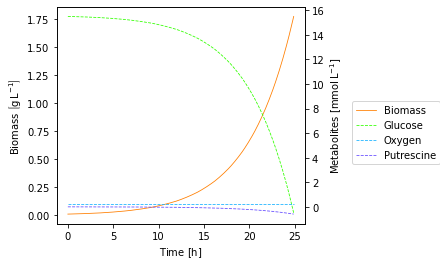

In [12]:
plot_concentrations(concentrations)

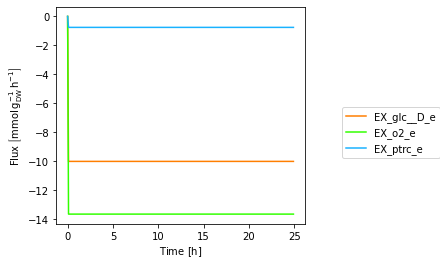

In [13]:
plot_trajectories(trajectories)

In [14]:
#Putrescine is not changing over time, this must mean we need to change the objective 